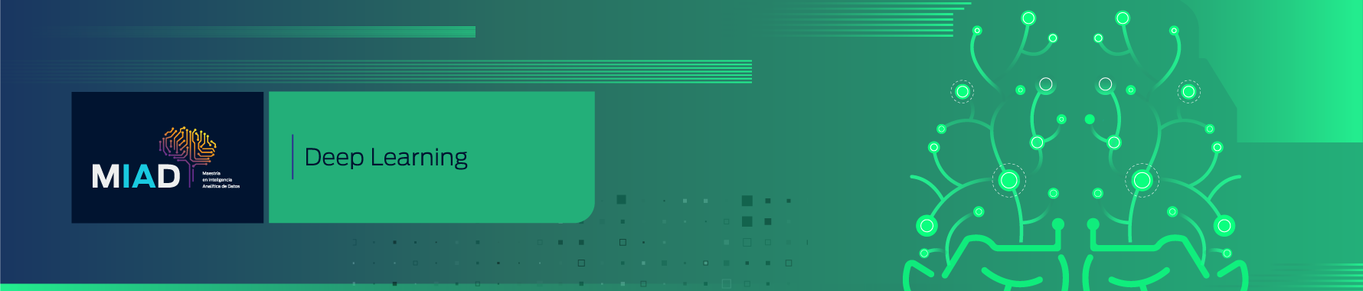

# Aplicaciones de Redes Convolucionales - Semana 6
## _Transfer Learning_ para nuevas tareas usando redes pre-entrenadas en Keras
### Laboratorio Sumativo

### Propósito de la actividad
En esta actividad mostraremos cómo usar redes convolucionales para visión computacional que ya han sido pre-entrenadas con grandes cantidades de datos, pero que quieren ser usadas con unos nuevos datos y para una tarea diferente.

Esto corresponde a la aplicación de _transfer learning_, en donde se remueven las últimas capas de una red pre-entrenada, y después de ponen nuevas capas entrenables adicionales. En _Keras_ este proceso también se conoce como _fine tunning_.

Otra opción, que es muy parecida al _transfer learning_ es usar capas intermedias de una red pre-entrenada y calcular las variables transformadas hasta esta capa. Estas variables, se pueden convertir en una nueva muestra de entrenamiento para un modelo de _machine learning_. En _Keras_ este proceso se conoce como _feature extraction_.


### Instrucciones generales

El laboratorio contiene dos partes, la primera (A) consiste en la explicación de _transfer learning_ usando la red VGG16, y la segunda (B) corresponde a la asignación del laboratorio sumativo.

Para la segunda parte, debe realizar la entrega correspondiente con la solución.

### Librerías a importar

A continuación se muestran los comandos a ejecutar para poder implementar los procedimientos de este notebook:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
#Las siguientes dos líneas evitan la generación de "warnings" y "flags" al importar keras y tensorflow.
#Dichas advertencias no comprometen el funcionamiento del código.
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#Importación de keras y tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
#from keras.preprocessing.image import ImageDataGenerator
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

### A. Uso de _CNN_ pre-entrenada para Aprendizaje por Transferencia

La estructura de modelo secuencial tipo CNN puede ser importada directamente sin necesidad de definir cada una de las capas, como conv2D, MaxPooling, etc. Muchas redes pueden ser implementadas automáticamente desde _Keras_ (https://keras.io/api/applications/). Sin embargo, muchas veces estas redes son bastante genéricas. Por ejemplo, muchas de ellas han sido entrenadas con los datos de _IMAGENET_ para clasificación multiclase, pero con alrededor de 1000 clases diferentes. Cuando requerimos un uso más específico, por ejemplo, reconocer la marca de un vehículo o el tipo de ambiente en una fotografía, este tipo de clasificación genérica no nos funciona muy bien.

La opción más directa, es hacer nuestra propia red convolucional desde cero con nuestros propios datos. Para esto, podemos tomas como inspiración muchas de las arquitecturas que ya han sido probadas (AlexNet, VGG16, GoogleNEt, ResNet, etc.). Sin embargo, es posible que, dado que nuestros datos corresponden a una aplicación más especializada, no tengamos a nuestra disposición la cantidad suficiente de imágenes para entrenar nuestra red. 

Otra opción más útil, sería usar como base de nuestro modelo, una red ya pre-entrenada. Por ejemplo, las primeras capas de una red tipo ResNet. El principio de este enfoque, es que las primeras capas todavía no se han especilizado completamente y son bastante genéricas en términos de reconocer patrones básicos que pueden funcionar en diversos problemas. Para estas primeras capas tomamos los pesos (estimación de los parámetros) ya fijos (recordemos que tenemos la opción de definir el parámetro "weights"). Sobre estas capas, podemos adicionar unas nuevas capas (generalmente son del tipo completamente conectadas) y entrenar los pesos de estas con los datos que tenemos a disposición para nuestro problema. 

Dentro de la calibración de los modelos de _Transfer Learning_, aparecen entonces nuevos hiper-parámetros que son necesarios de calibrar, como el número de capas del modelo base ya preentrenado y el número de capas entrenables adicionales. Esto depende, por supuesto, de la cantidad de imágenes que tengamos disponibles y de la complejidad de la tarea. 

#### _Transfer Learning_ en Keras usando VGG16

La forma más sencilla de usar _transfer learning_ con redes pre-entrenadas, es cargando la red con los pesos fijos, como por ejemplo en el modelo VGG16, usando  `weights='imagenet'`, que incluye los valores de todos los parámetros ya entrenados con los datos descritos del ILSVRC. Sin embargo, en este caso el parámetro `include_top`, que hace referencia a si se incluyen las últimas 3 capas de tipo completamente conectadas (_fully connected_) se define como `False`, dado que se reemplazarán por capas nuevas.

Además de esto, es necesario añadir las capas nuevas con las cuales crearemos nuestro modelo. Una vez se tiene la configuración del modelo, se fijan los valores de las primeras capas, haciendo para cada una de las _layers_ que no se entrenan `layer.trainable = False`.

Miremos la implementación usando la red VGG16 contenida en _Keras Applications_:

In [5]:
#Importar modelo entrenado VGG16 con las últimas capas
#Puede tomar algunos segundos
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Sobre este modelo, el primer paso (que es opcional), es usar una operación de _pooling_ global sobre la salida de la última capa ("block5_pool"), para pasar a una arreglo en una dimensión de tamaño [1,1,512].

In [6]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base=GlobalAveragePooling2D()(vgg.output)

Después, se pueden adicionar capas completamente conectadas ("Dense") de diferentes tamaños. En este caso, añadimos una capa de 256 nodos con activación RELU:

In [7]:
new=Dense(128,activation='relu')(base)

De la misma forma, es posible adicionar capas adicionales. 

Supongamos que el nuevo problema que queremos resolver es de reconocimiento de imágenes con 5 clases diferentes de objetos. Para esto, es necesario crear la capa de salida:

In [8]:
out_layer=Dense(5,activation='softmax')(new)

El último paso antes de compilar el modelo, es fijar las capas cuyos pesos queremos que se mantengan fijos, mientras que las capas restantes se dejan libres para entrenar. En este caso, todas las capas anteriores del VGG16 a las capas completamente conectadas se dejarán fijas:

In [9]:
for layer in vgg.layers:
    layer.trainable = False

Ahora se puede definir el nuevo modelo que va desde los _inputs_ del modelo base (VGG) hasta la capa de salida definida:

In [10]:
from tensorflow.keras.models import Model

model=Model(inputs=vgg.input,outputs=out_layer)

Y con esto, ya es posible compilar el modelo. En este caso usamos _Adam_ con un problema de clasificación multiclase. Puede ser definido a conveniencia para calibrar el modelo en términos de hiper-parámetros:

In [11]:
from keras.optimizers import Adam
model.compile(optimizer= Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.995), loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

***
#### Problema de reconocimiento de imágenes y datos a usar

En este caso, resolveremos un problema de identificación de especies de flores. Se tienen 5 diferentes especies que salen en los datos: daisy (margarita), dandelion (diente de león), roses (rosas), sunflowers (girasoles), y tulips (tulipanes). La base de datos contiene en total 3670 imágenes en color  y se obtiene directamente de un repositorio usando las herramientas de Tensorflow para carga de datos:

In [12]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Miremos primero el número total de imágenes:

In [13]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Y algunas imágenes de muestra:

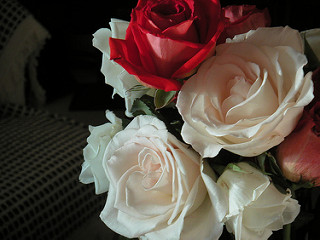

In [14]:
import PIL
import PIL.Image
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

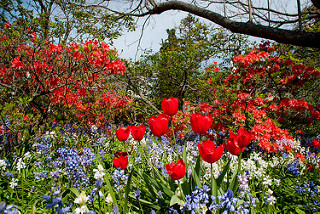

In [15]:
import PIL
import PIL.Image
roses = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(roses[4]))

Ahora definimos los datos para entrenamiento y para validación (`train_ds` y `val_ds` respectivamente) usando un tamaño de 224 por 224, para que sea compatible con VGG16:

In [16]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Revisemos las dimensiones en cada uno de los conjuntos de datos:

In [17]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


Por último, antes de usar los datos, los escalamos para que estén en el rango [0,1], y no tengamos problemas en el entrenamiento:

In [18]:
from tensorflow.keras import layers

scale_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (scale_layer(x), y))
val_ds = val_ds.map(lambda x, y: (scale_layer(x), y))

Con estos elementos ya es posible entrenar el modelo usando "model.fit". _Nota:_ El "warning" referente al uso de funciones `lambda` no representa un problema ni afecta la ejecución del código y será eliminado en próximas versiones de Tensorflow.

A continuación, se entrenará el modelo compilado. Dicho entrenamiento toma alrededor de 3 horas en el kernel de Coursera, por lo que se recomienda ejecutar todo el código de una sola vez en la opción "Cell -> Run All" para evitar que el kernel se cierre por largo tiempo de ejecución.

In [19]:
epochs = 10
model_train = model.fit(train_ds,epochs=epochs,verbose=1,validation_data=val_ds)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 368s 4s/step - accuracy: 0.5396 - loss: 1.1882 - val_accuracy: 0.7439 - val_loss: 0.6922
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 372s 4s/step - accuracy: 0.7654 - loss: 0.6253 - val_accuracy: 0.7997 - val_loss: 0.5261
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 376s 4s/step - accuracy: 0.8284 - loss: 0.4915 - val_accuracy: 0.7943 - val_loss: 0.5534
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - accuracy: 0.8303 - loss: 0.4746 - val_accuracy: 0.8038 - val_loss: 0.5228
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 368s 4s/step - accuracy: 0.8513 - loss: 0.4037 - val_accuracy: 0.8283 - val_loss: 0.4830
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 367s 4s/step - accuracy: 0.8588 - loss: 0.3841 - val_accuracy: 0.8038 - val_loss: 0.5287
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 367s 4s/step - accuracy: 0.8565 - loss: 0.3834 - val_accuracy: 0.8215 - val_loss: 0.4807
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 366s 4s/step - accuracy: 0.8886 - loss: 0.3188 - val_accuracy: 0.8338 - v

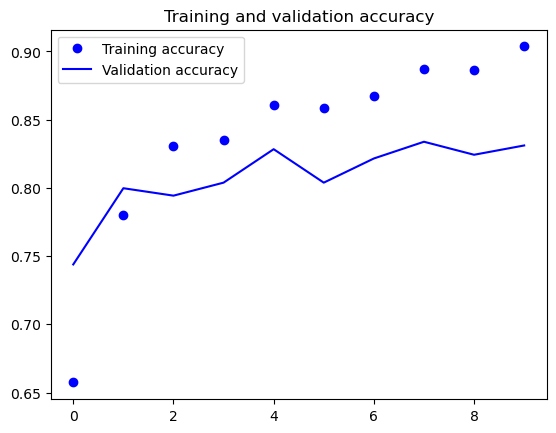

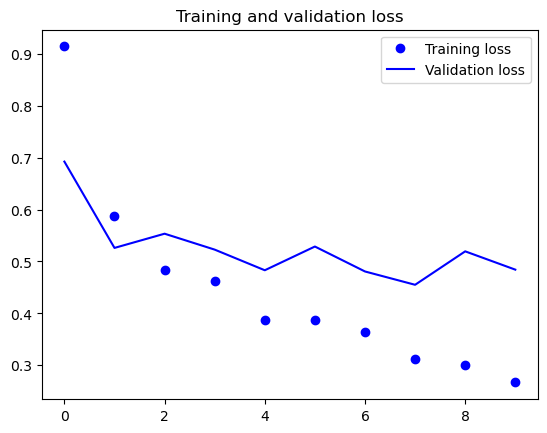

In [20]:
accuracy = model_train.history['accuracy']
val_accuracy = model_train.history['val_accuracy']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

***
### B. Laboratorio Sumativo _Transfer Learning_

El laboratorio consiste en hacer _transfer learning_ usando los datos de flores que se cargaron y con la partición que se hizo para entrenamiento y validación. Sin embargo, en lugar de usar la red VGG16, usaremos la red Inception, la cual también está disponible en Keras (https://keras.io/api/applications/inceptionv3/). *Nota:* Tenga en cuenta que, debido a que la implementación de estos algoritmos toma varias horas, es muy probable que el kernel de Coursera se reinicie durante la corrida de alguno de los siguientes puntos. Por lo tanto, se recomienda ejecutar este notebook en un computador local o en Google Colab.


#### 1. Adaptación de la red InceptionV3 para _transfer learning_ [30 puntos]

Acá, debe preparar la red InceptionV3 para _transfer learning_. Para ello, debe remover las capas finales (completamente conectadas) usando la opción `top=False`.

Además, después de usar "global pooling" para linealizar los datos, agregará una capa adicional completamente conectada con el número de nodos que considere adecuado (hiper-parámetro de calibración). Por último, debe agregar la capa de salida para el problema. No olvide que los parámetros anteriores a las últimas capas no son entrenables.

In [38]:
from tensorflow.keras.applications import InceptionV3

# Cargar el modelo pre-entrenado InceptionV3 sin las capas finales
inception = InceptionV3(weights='imagenet', include_top=False)


# Congelar las capas base (parámetros anteriores a las últimas capas)
for layer in inception.layers:
    layer.trainable = False


# Agregar una capa de Global Avptioanerage Pooling para linealizar los datos
x = GlobalAveragePooling2D()(inception.output)

# Agregar una capa completamente conectada adicional con el número de nodos deseado
x = Dense(256, activation='relu')(x)  # Puedes ajustar el número de nodos según sea necesario

# Agregar la capa de salida para el problema de clasificación de flores (5 clases)
outputs = Dense(5, activation='softmax')(x)

# Crear el nuevo modelo que incluya la red InceptionV3 y nuestras capas personalizadas
modelInception  = Model(inputs=inception.input, outputs=outputs)

# Resumen del modelo
modelInception.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_470 (Conv2D) │ (None, None,      │        864 │ input_layer_7[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_470[0][0]  │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_470      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_471 (Conv2D) │ (None, None,      │      9,216 │ activation_470[0… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_471[0][0]  │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_471      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_472 (Conv2D) │ (None, None,      │     18,432 │ activation_471[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_472[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_472      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, None,      │          0 │ activation_472[0… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_473 (Conv2D) │ (None, None,      │      5,120 │ max_pooling2d_20… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_473[0][0]  │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_473      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_474 (Conv2D) │ (None, None,      │    138,240 │ activation_473[0… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_474[0][0]  │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_474      │ (None, None,      │          0 │ batch_normalizat

 Total params: 22,328,613 (85.18 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

#### 2. Estimación del modelo propuesto y calibración de gradiente descendiente [20 puntos]
Usando el modelo propuesto, estime los parámetros asociados. No olvide calibrar el modelo con los algoritmos de estimación correspondiente. También puede considerar un capa de _dropout_ antes de la capa de salida.

In [40]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy


# Crear el nuevo modelo que incluya la red InceptionV3, nuestras capas personalizadas y la capa de salida
modelInception = Model(inputs=inception.input, outputs=outputs)

# Compilar el modelo con el algoritmo de optimización Adam y la función de pérdida SparseCategoricalCrossentropy
modelInception.compile(optimizer=Adam(learning_rate=0.001), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])


# Entrenar el modelo Inception
Inception_history = modelInception.fit(train_ds, epochs=10, verbose=1, validation_data=val_ds)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 90s 916ms/step - accuracy: 0.6629 - loss: 0.9277 - val_accuracy: 0.8638 - val_loss: 0.4047
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 88s 951ms/step - accuracy: 0.8762 - loss: 0.3263 - val_accuracy: 0.8719 - val_loss: 0.3556
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.8998 - loss: 0.2668 - val_accuracy: 0.8815 - val_loss: 0.3484
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9396 - loss: 0.1806 - val_accuracy: 0.8706 - val_loss: 0.3663
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9490 - loss: 0.1463 - val_accuracy: 0.8665 - val_loss: 0.3763
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 89s 970ms/step - accuracy: 0.9630 - loss: 0.1095 - val_accuracy: 0.8801 - val_loss: 0.3774
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 988ms/step - accuracy: 0.9824 - loss: 0.0690 - val_accuracy: 0.8747 - val_loss: 0.3790
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 92s 998ms/step - accuracy: 0.9904 - loss: 0.0476 - val_accuracy: 0.8

#### 3. Comparación con modelos VGG16 sin _transfer learning_ [20 puntos]
Para revisar si hacer _transfer learning_ tiene alguna utilidad en el modelo, ahora deberá estimar todos los parámetros de la red VGG16 (con todos los parámetros estimables), tenga en cuenta que esto puede tardar bastante. Compare los resultados en la muestra de validación.

In [30]:
# Cargar el modelo pre-entrenado VGG16 con todas las capas (incluyendo las completamente conectadas)
vgg16 = VGG16(weights='imagenet', include_top=True)

# Compilar el modelo VGG16
vgg16.compile(optimizer= Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.995), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Resumen del modelo VGG16
vgg16.summary()

# Entrenar el modelo VGG16
vgg16_history = vgg16.fit(train_ds, epochs=10, verbose=1, validation_data=val_ds)



553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1055s 11s/step - accuracy: 0.1818 - loss: 4891549696.0000 - val_accuracy: 0.2139 - val_loss: 1.6798
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1111s 12s/step - accuracy: 0.2305 - loss: 1.6520 - val_accuracy: 0.2139 - val_loss: 1.6444
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1109s 12s/step - accuracy: 0.2389 - loss: 1.6117 - val_accuracy: 0.2071 - val_loss: 1.6142
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1109s 12s/step - accuracy: 0.2094 - loss: 1.7889 - val_accuracy: 0.2071 - val_loss: 1.6119
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1103s 12s/step - accuracy: 0.2196 - loss: 1.6121 - val_accuracy: 0.2398 - val_loss: 1.6051
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1102s 12s/step - accuracy: 0.2472 - loss: 1.6009 - val_accuracy: 0.2398 - val_loss: 1.6090
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1101s 12s/step - accuracy: 0.2404 - loss: 2.0271 - val_accuracy: 0.1635 - val_loss: 6.0336
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1096s 12s/step - accuracy: 0.2105 - loss: 66.2756 

In [34]:

# Comparar los resultados en la muestra de validación
# Por ejemplo, puedes comparar la precisión de ambos modelos en la muestra de validación
vgg_transfer_results = model.evaluate(val_ds)
vgg16_results = vgg16.evaluate(val_ds)

print("VGG16 (Transfer Learning) - Accuracy:", vgg_transfer_results[1])
print("VGG16 (Sin Transfer Learning) - Accuracy:", vgg16_results[1])



23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 734ms/step - accuracy: 0.1880 - loss: 2.0209
23/23 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.2323 - loss: 1.6026
VGG16 (Transfer Learning) - Accuracy: 0.18119890987873077
VGG16 (Sin Transfer Learning) - Accuracy: 0.23978202044963837


#### 4. _Transfer learning_ con reuso de parámetros (_fine tunning_) [30 puntos]
En la práctica es común que después de hacer _transfer learning_, los parámetros de la red, o de algunas de las últimas capas que no se habían entrenado se liberan para que sean entrenadas.

Acá, debe tomar la red que estimó en el punto 1 por _transfer learning_ y la solución la debe tomar como los valores iniciales de una nueva red, en la cual simplemente se dejan entrenables las dos últimas capas de InceptionV3 que se habían dejado no entrenables.

Compare los resultados con los modelos anteriores.

In [42]:
# Congelar todas las capas excepto las últimas dos
for layer in modelInception.layers[:-2]:
    layer.trainable = False

# Recompilar el modelo para que los cambios surtan efecto
modelInception.compile(optimizer=Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Resumen del modelo actualizado
modelInception.summary()

# Entrenar el modelo con fine-tuning
fine_tuning_history = modelInception.fit(train_ds, epochs=5, verbose=1, validation_data=val_ds)

# Comparar los resultados con los modelos anteriores
fine_tuning_results = modelInception.evaluate(val_ds)

#print("InceptionV3 con Fine-tuning - Accuracy:", fine_tuning_results[1])
#print("InceptionV3 con Transfer Learning - Accuracy:", inception_results[1])
#print("VGG16 sin Transfer Learning - Accuracy:", vgg16_results[1])

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_470 (Conv2D) │ (None, None,      │        864 │ input_layer_7[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_470[0][0]  │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_470      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_471 (Conv2D) │ (None, None,      │      9,216 │ activation_470[0… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_471[0][0]  │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_471      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_472 (Conv2D) │ (None, None,      │     18,432 │ activation_471[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_472[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_472      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, None,      │          0 │ activation_472[0… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_473 (Conv2D) │ (None, None,      │      5,120 │ max_pooling2d_20… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_473[0][0]  │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_473      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_474 (Conv2D) │ (None, None,      │    138,240 │ activation_473[0… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_474[0][0]  │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_474      │ (None, None,      │          0 │ batch_normalizat

 Total params: 22,328,613 (85.18 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 96s 976ms/step - accuracy: 0.9979 - loss: 0.0178 - val_accuracy: 0.8924 - val_loss: 0.3846
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 984ms/step - accuracy: 1.0000 - loss: 0.0118 - val_accuracy: 0.8896 - val_loss: 0.3971
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 89s 964ms/step - accuracy: 1.0000 - loss: 0.0114 - val_accuracy: 0.8924 - val_loss: 0.4050
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 88s 958ms/step - accuracy: 1.0000 - loss: 0.0104 - val_accuracy: 0.8869 - val_loss: 0.4045
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 90s 977ms/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 0.8883 - val_loss: 0.4205
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 768ms/step - accuracy: 0.8854 - loss: 0.4462
